# Handling overfitting in deep learning modules

Overfitting, when a model performs well on training data but does not generlize well on new data can make a model useless or even damaging in certain instances. We can reduce overfitting most simply by getting more training data. However, in the real world just getting more data is not always an option. Therefore, other methods must be used to lower the capacity of the model to memorize training data.

This notebook will explore those methods while using Twitter US Airline Sentiment data from Kaggle.

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

root = Path('../')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

**Helper functions**

In [2]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

**Data preparation:**
* Data cleaning
* Train-test split
* Converting words to numbers
* Converting the target classes to numbers
* Splitting off a validation set

A csv file with tweets will be shuffled before splitting into train and test sets. We only need the *text* column as input and the *airline_sentiment* column as the target.

We are also removing stopwords since they do not help predict sentiment. Since we want to build a model that can generalize to any airline, the mentions are also being removed.

In [3]:
df = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

Here, we create our test and train splits.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

We will be keeping the most frequently used words as integers in a dictionary. We apply a filter to ignore special characters and shift all the words to lowercase.

In [5]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

Now that the words are held in a dictionary, we will use NB_WORDS values to indicate whether the word is present in the tweet or not. This is a binary value.

In [6]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

The target classes are also converted to numbers and then one-hot encoded.

In [7]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

The data is ready to be split off into a validation set to evaluate the model performance.

In [8]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

**Deep learning**

The model will overfit intentionally. It has 2 densely connected layers of 64 nodes. The *input_shape* for the first layer is equal to the number of words in the dictionary.

We will be working with 3 different sentiment classes, therefore, the last layer has 3 nodes. *Softmax* activation will create a probability vector with a sum of 1.

The number of parameters to train is as follows:

* First layer: (10000\*64) + 64 = 640064
* Second layer: (64\*64) + 64 = 4160
* Last layer: (64\*3) + 3 = 195

In [9]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model._name = 'baseline_model'

We use *categorical_crossentropy* as the loss function since this project is a multi-class, single-label prediction. 

Minimum validation loss reached in epoch 3


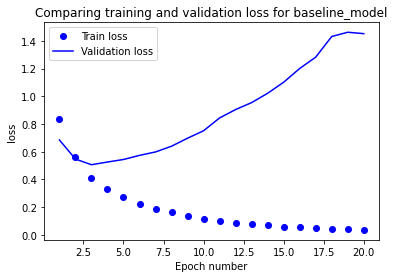

In [10]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

At first, *validation loss* goes down but by epoch 3 this stop and instead the *validation loss* increases. This is indicative of a model that overfits.

The *training loss* continues to go down until it hits nearly zero by epoch 20. This is the "memorization" of training data.

**Handling overfitting:**
* Reduce the network's capacity
* Apply regularization
* Dropout layers

The first model had a large number of trainable parameters. The higher the number of parameters, the easier it is for the model to memorize the target class for each training sample. This makes for poor generalization when interpreting new data.

By lowering the capacity of the network, the model must learn the patterns that matter (the patterns that minimize loss). Reducing the capacity too much, however, can cause *underfitting*. Essentially, the model will not learn relevant patterns from training.

Our second model will remove one hidden layer and reduce the number of nodes to 16.

Minimum validation loss reached in epoch 14


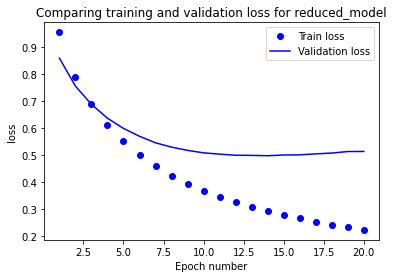

In [11]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model._name = 'reduced_model'
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

Now, it takes more epochs before the model starts overfitting and the validation loss rises slower.

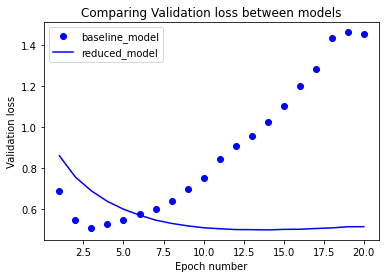

In [12]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

**L1 regularization and L2 regularization**

*L1 regularization* adds a cost with regards to the *absolute value of the parameters*. Some of the weights will be equal to zero.

*L2 regularization* adds a cost with regards to the *squared value of the parameteres*. The weights will be smaller.

We will use L2 regularization.

In [13]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model._name = 'l2_Regularization_model'
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch 4


The model still overfits in the same epoch, however, the loss increases more slowly.

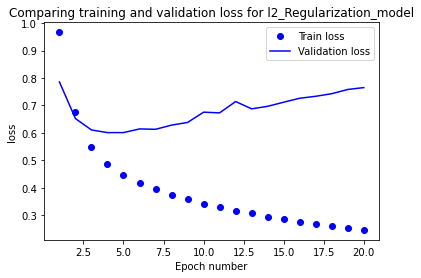

In [14]:
eval_metric(reg_model, reg_history, 'loss')

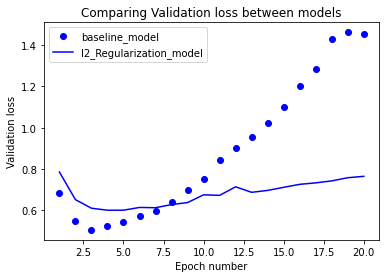

In [15]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

**Dropout layers**

Dropout will randomly set output features of a layer to zero. With dropout layers, the model starts overfitting later than the baseline model and loss increases slower than the baseline model.

Minimum validation loss reached in epoch 6


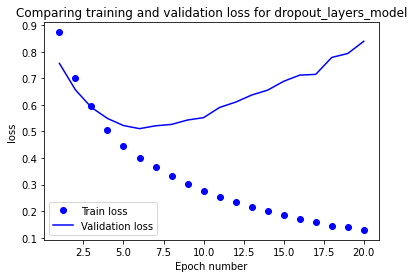

In [16]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model._name = 'dropout_layers_model'
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

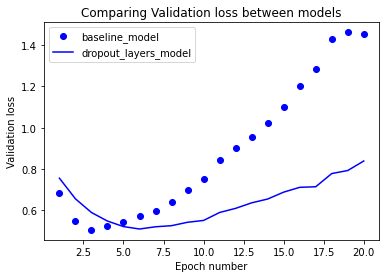

In [17]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

**Training on the full train data and evaluation on test data**

In [18]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 2ms/step - loss: 1.1006 - accuracy: 0.7616

Test accuracy: 76.16%
46/46 [==============================] - 0s 2ms/step - loss: 0.6540 - accuracy: 0.7828

Test accuracy: 78.28%
46/46 [==============================] - 0s 3ms/step - loss: 0.7615 - accuracy: 0.7780

Test accuracy: 77.80%
46/46 [==============================] - 0s 2ms/step - loss: 0.8818 - accuracy: 0.7801

Test accuracy: 78.01%


# Conclusion
All three of the options we explored (reduced network capacity, regularization, and dropout layers) help to reduce overfitting. We can see the each method had at least a 1% gain over the original model.